In [ ]:
fn1 = "ziyi"
ln1 = "liu"
filename = "_".join(map(lambda s: s.strip().lower(),
["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
print(filename)

sd-tsia204_lab2_liu_ziyi.ipynb


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

1) a) Load the data, and calculate size, mean, standard deviation, minimum, maximum with describe()

In [ ]:
random_seed = 0
data = pd.read_csv('/content/meatspec.csv')
print(data.describe())

               V1          V2          V3          V4          V5          V6  \
count  215.000000  215.000000  215.000000  215.000000  215.000000  215.000000   
mean     2.808561    2.811137    2.813727    2.816363    2.819098    2.821983   
std      0.410793    0.413352    0.415906    0.418465    0.421040    0.423635   
min      2.066420    2.065830    2.065180    2.064650    2.064170    2.063730   
25%      2.512265    2.513260    2.514210    2.515330    2.516775    2.518240   
50%      2.753600    2.755180    2.756680    2.758240    2.759860    2.761610   
75%      3.006155    3.010470    3.014840    3.019260    3.025895    3.032780   
max      4.237280    4.247210    4.257370    4.267730    4.278470    4.289680   

               V7          V8          V9         V10  ...         V92  \
count  215.000000  215.000000  215.000000  215.000000  ...  215.000000   
mean     2.825064    2.828375    2.831943    2.835813  ...    3.178262   
std      0.426245    0.428866    0.431510    0.4

b) We can see that mean not 0; std not 1; data not between [-1,1] or [0,1]

  So the data is not centered, not standardized, not normalized

c) Then use train_test_split to generate the train and test set and use standardscaler to do the standardization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = data["fat"]
X = data.drop(["fat"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train) #transform() : When normalizing the data on the test set, the minimum and maximum values of the training set are used
X_test_norm = sc.transform(X_test)

y_train = np.array(y_train).reshape(-1, 1) #reshape y from (n,) to (n,1)
y_test = np.array(y_test).reshape(-1, 1)
y_train_norm = sc.fit_transform(y_train)
y_test_norm = sc.transform(y_test)

d) Fit a reguler OLS, because the data is already centralized, so we don't need to fit the intercept. We can see that the  θ0 is is close to 0

In [ ]:
from sklearn.linear_model import LinearRegression
ls = LinearRegression()
ls.fit(X_train_norm, y_train_norm)
theta0 = ls.intercept_
theta = ls.coef_[0]
print(theta0, theta)

[6.19087183e-12] [ 3.26788372e+02 -2.65147231e+02 -6.49770215e+02  1.56508427e+03
 -1.86777971e+03  1.18017547e+03 -7.23843419e+02  3.56584868e+02
  1.04409417e+02 -2.31286290e+02 -1.68698350e+02  1.53975162e+03
 -1.79304229e+03  1.23138401e+03 -5.87599896e+02 -3.11315315e+02
 -3.06125977e-01  3.10041307e+02  5.83704196e+02 -6.84632438e+02
 -9.66918794e+02  2.06177642e+03 -7.91814258e+02 -9.39468234e+02
  9.48597488e+02 -1.78686106e+02 -5.92809347e+01  7.34297959e+02
 -1.58570299e+03  1.24925560e+03 -5.88650909e+02  4.44384945e+02
 -1.25120255e+02 -6.64703414e+01 -5.20370753e+02  4.49277395e+02
 -9.18801073e+01 -1.95555463e+02  1.13059830e+03 -1.56930471e+03
  1.73402235e+03 -1.68810384e+03  9.29178200e+02 -6.58908798e+02
  7.26246231e+02 -8.07490401e+01 -2.93634391e+02  1.07653397e+02
  2.97962966e+02 -1.24102298e+03  1.75122510e+03 -1.02274437e+03
 -4.79684361e+02  1.52619449e+03 -1.11130503e+03  1.56099416e+02
 -5.57225479e+01  2.75809541e+02 -3.90697133e+02  6.00953731e+02
 -3.4476

e) Calculate the R2 score of OLS model

In [ ]:
from sklearn.metrics import r2_score

y_predict_OLS = ls.predict(X_test_norm)
r2_regular_OLS = r2_score(y_test_norm, y_predict_OLS)
print("R2 - OLS : ", r2_regular_OLS)

df_coef = pd.DataFrame([r2_regular_OLS], columns=["r2"]) #Create df_coef

R2 - OLS :  0.9600547777988199


2) Apply the forward selection algo in Lecture notes P26

Store selection order and p-value in list

In [ ]:
import statsmodels.api as sm

def p_value(Y, Xk): #Calculate the p-value with H0: parameter of k-th column=0
  model = sm.OLS(Y,Xk)
  results = model.fit()
  return results.pvalues[0]

def gram(Xk):
  return np.dot(Xk.T, Xk)/len(Xk)

def sigma(Y, Xk):
  return np.square(np.linalg.norm(Y-thetan(Y, Xk)*Xk, ord = 2))/(len(Xk)-2)

def thetan(Y, Xk):
  ls = LinearRegression()
  ls.fit(Xk,Y)
  return ls.coef_[0]

def T(Y, Xk): #Calculate the value of Tn, lecture notes P25
  return thetan(Y, Xk)/gram(Xk)*sigma(Y, Xk)

n, p = X_train_norm.shape

#Algorithm lecture notes P26
A = [i for i in range(0, p)]
order = []
p_list = []
Tn_list = []
max = float('-inf')
r = y_train_norm
while len(A) != 0: #Until all the variables are used
  max = float('-inf')
  Tn_list = []
  for i in range(0, p): #Find the biggest Tn
    Xk = np.array(X_train_norm[:, i]).reshape(-1, 1) #Get the i-th column of X_train_norm
    Tn = T(r, Xk)
    Tn_list.append(Tn)
    if Tn > max and i not in order:
      max = Tn
    
  Xk_star = np.array(X_train_norm[:, Tn_list.index(max)]).reshape(-1, 1) #The chosen Xk
  p_list.append(p_value(y_train_norm, np.delete(X_train_norm, Tn_list.index(max), axis=1))) #Add the corresponding p-value to the list
  r = r - np.dot(Xk_star, thetan(y_train_norm, Xk_star).reshape(-1, 1)) #Update r
  order.append(Tn_list.index(max)) #Add the chosen index to the list
  A.remove(Tn_list.index(max)) #Remove the chosen index in A
print(order)
print(p_list)


[40, 39, 7, 6, 8, 5, 9, 4, 10, 3, 11, 2, 12, 1, 13, 0, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 48, 49, 47, 50, 46, 32, 51, 45, 33, 34, 52, 44, 35, 36, 43, 53, 37, 42, 38, 41, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0.03527225239042153, 0.051751516488382006, 0.04356272039379165, 0.027252427918957364, 0.05451769071304152, 0.030111474770245592, 0.052133466490425495, 0.024436051796228896, 0.052965463572564535, 0.033860515185688264, 0.10963078086537677, 0.04282623945449439, 0.10342007966293516, 0.0459958530524479, 0.08267520587867838, 0.3575059629678844, 0.06051807794780814, 0.05532893650872723, 0.050121379849752026, 0.057670619022903276, 0.039400069181092824, 0.03844905831754735, 0.05987435481140776, 0.0589889128674131, 0.05313673158483308, 0.04580695713158885, 0.05078296353816907, 0.048621672144497086, 0.0470871884

3) Run OLS on the variables with a p-value smaller than 0.05

Calculate R2 for my foward selection model

In [ ]:
"""
#Another methode calcule p-values by statsmodels.api
import statsmodels.api as sm
model = sm.OLS(y_train_norm, X_train_norm)
results = model.fit()
x_forward_selec = []
for i in range(0, p):
  if results.pvalues[i] < 0.05:
    x_forward_selec.append(i)
print(x_forward_selec)

[3, 28, 59]
"""
x_forward_selec = []
for i in range(0, p):
  if p_list[i] < 0.05:
    x_forward_selec.append(order[i])
print(x_forward_selec) #Index of X, chosen by p-value < 0.05

ls_forward_selec = LinearRegression()
ls_forward_selec.fit(X_train_norm[:, x_forward_selec], y_train_norm) #OLS for X chosen
theta_forward_selec = ls_forward_selec.coef_[0]

y_predict_forward_selec = 0
for i in range(0, len(x_forward_selec)):
  y_predict_forward_selec += theta_forward_selec[i]*X_test_norm[:, x_forward_selec[i]] #Calcule y predict
r2_forward_selec = r2_score(y_test_norm, y_predict_forward_selec) #Calcule R2 value
print("R2 - forward selection : ", r2_forward_selec)

df_coef.loc[len(df_coef)] = r2_forward_selec #Add new R2 score of my foward selection model to df_coef
print(df_coef)

[40, 7, 6, 5, 4, 3, 2, 1, 18, 19, 23, 25, 26, 27, 31, 32, 45, 33, 52, 44, 35, 36, 43, 53, 42, 41, 54, 55, 58, 59, 60, 66, 67, 70, 74, 76, 77, 78, 85, 88, 89, 90, 92, 94, 95]
R2 - forward selection :  0.9611485035830734
         r2
0  0.960055
1  0.961149


4）The parameters of these two selections are different because in my forward selection, I compare with the test of no effect and chose by p-values less than 0.05, while in SFS find the best features based on cross-validation scores and estimates

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=len(x_forward_selec), direction="forward")
sfs.fit(X_train_norm, y_train_norm)
sfs_selec = []
for i in range(0, len(sfs.get_support())):
  if sfs.get_support()[i] == True:
    sfs_selec.append(i)
print(sfs_selec) #Index of X chosen by sfs

ls_sfs_selec = LinearRegression()
ls_sfs_selec.fit(X_train_norm[:, sfs_selec], y_train_norm)
theta_sfs_selec = ls_sfs_selec.coef_[0]

y_predict_sfs_selec = 0
for i in range(0, len(sfs_selec)):
  y_predict_sfs_selec += theta_sfs_selec[i]*X_test_norm[:,sfs_selec[i]]
r2_regular_sfs_selec = r2_score(y_test_norm,y_predict_sfs_selec)
print("R2 - Sequential Feature Selector : ", r2_regular_sfs_selec)

df_coef.loc[len(df_coef)] = r2_regular_sfs_selec #Add new R2 score of Sequential Feature Selector
print(df_coef)

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 57, 58, 59, 60, 74, 77, 87, 90, 97, 99]
R2 - Sequential Feature Selector :  0.9489768213755535
         r2
0  0.960055
1  0.961149
2  0.948977


5) Define Ridge function, theta is given by lecture note P30

In [ ]:
def theta_ridge(y, X, alpha):
  return np.linalg.inv(np.dot(X.T, X) + alpha*np.eye(p))@X.T@y

a) Values of the coefficients Vt changes with α

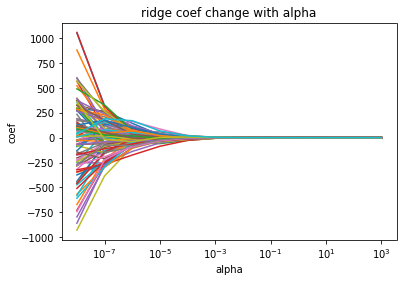

In [ ]:
alpha=[10e-9, 10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2]
for t in range(0, p): #For each features
  theta_ridge_Vp = []
  for i in alpha: #For each alpha
    theta_ridge_Vp.append(theta_ridge(y_train_norm, X_train_norm, i)[t])
  plt.plot(alpha, theta_ridge_Vp, label="coef{}".format(t)) #plot the t-th coef change with alpha
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("coef")
plt.title("ridge coef change with alpha")
#plt.legend(loc="upper right")
plt.show()

b) Values of MSE change with α for test set and train set

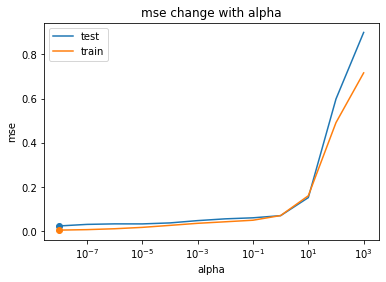

In [ ]:
from sklearn.metrics import mean_squared_error

mse_list_test = []
mse_list_train = []
for i in alpha:
  thetan_ridge = theta_ridge(y_train_norm, X_train_norm, i)

  y_predict_ridge_test = 0
  for i in range(0,len(thetan_ridge)):
    y_predict_ridge_test += thetan_ridge[i]*X_test_norm[:, [i]] #Calcule y predict for test set
  #mse_test = np.sum((y_test_norm - y_predict_ridge_test)**2)/len(y_test_norm) 
  mse_test = mean_squared_error(y_test_norm, y_predict_ridge_test) #Calcule MSE for test set
  mse_list_test.append(mse_test)

  #Same thing for train set
  y_predict_ridge_train = 0
  for i in range(0,len(thetan_ridge)):
    y_predict_ridge_train += thetan_ridge[i]*X_train_norm[:, [i]]
  #mse_train = np.sum((y_train_norm - y_predict_ridge_train)**2)/len(y_train_norm)
  mse_train = mean_squared_error(y_train_norm, y_predict_ridge_train)
  mse_list_train.append(mse_train)

#Find the min mse point
min_test = float('inf')
for i in mse_list_test:
  if i < min_test:
    min_test = i 
#print(alpha[mse_list_test.index(min_test)])

min_train = float('inf')
for i in mse_list_train:
  if i < min_train:
    min_train = i
#print(alpha[mse_list_train.index(min_train)])

alpha_min = alpha[mse_list_test.index(min_test)]

plt.plot(alpha, mse_list_test, label="test")
plt.plot(alpha, mse_list_train, label="train")
plt.scatter(alpha[mse_list_test.index(min_test)], min_test) #Plot the point where MSE is at its minimum for test set
plt.scatter(alpha[mse_list_train.index(min_train)], min_train)
plt.legend()
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("mse")
plt.title("mse change with alpha")
plt.show()

c) for the best performing value of α (the one with smallest training error) store the R2 results

In [ ]:
thetan_ridge_min = theta_ridge(y_test_norm, X_test_norm, alpha_min)

y_predict_ridge_min = 0
for i in range(0,len(thetan_ridge_min)):
  y_predict_ridge_min += thetan_ridge_min[i]*X_test_norm[:,[i]]
r2_ridge = r2_score(y_test_norm, y_predict_ridge_min)
print(r2_ridge)

df_coef.loc[len(df_coef)] = r2_ridge #Add new R2 score of ridge model
print(df_coef)

0.9999004336225551
         r2
0  0.960055
1  0.961149
2  0.948977
3  0.999900


6) Sklearn lasso model

a) These warning arise because the Lasso class of sklearn uses the coordinate descent instead of least square, it brings iteration and convergence problems

To solve this problem, we can increase the number of iterations or increase the regularization parameter α, or increase tol but this may cause the algorithm to stop early and reach a suboptimal solution

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+00, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.017e-01, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e-01, tolerance: 1.610e-02

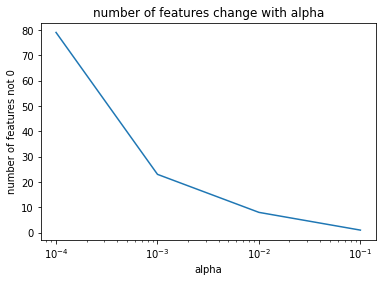

In [ ]:
from sklearn.linear_model import Lasso

alpha_lasso = [10e-5, 10e-4, 10e-3, 10e-2]

number_feat = []
for i in alpha_lasso:
  lasso = Lasso(alpha=i, tol=0.0001, max_iter=10000)
  lasso.fit(X_train_norm, y_train_norm)
  number = 0
  for c in lasso.coef_: #Count the number of non-zero theta
    if c != 0:
      number += 1
  number_feat.append(number)

plt.plot(alpha_lasso, number_feat)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("number of features not 0")
plt.title("number of features change with alpha")
plt.show()

b) Values of MSE change with α in lasso model

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.239e-01, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e-02, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(


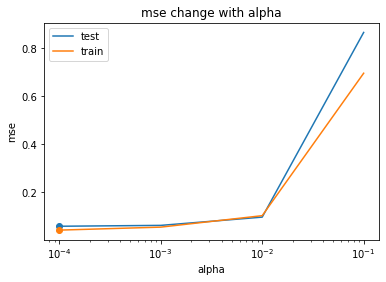

In [ ]:
from sklearn.metrics import mean_squared_error

mse_list_lasso_test = []
mse_list_lasso_train = []
for i in alpha_lasso:
  lasso = Lasso(alpha=i, tol=0.0001, max_iter=100000)
  lasso.fit(X_train_norm, y_train_norm) #Fit the lasso model

  y_predict_lasso_test = lasso.predict(X_test_norm) #Calculate y_predict
  mse_test = mean_squared_error(y_test_norm, y_predict_lasso_test) #Calculate MSE
  mse_list_lasso_test.append(mse_test)

  y_predict_lasso_train = lasso.predict(X_train_norm)
  mse_train = mean_squared_error(y_train_norm, y_predict_lasso_train)
  mse_list_lasso_train.append(mse_train)

min_test = float('inf')
for i in mse_list_lasso_test:
  if i < min_test:
    min_test = i
#print(alpha_lasso[mse_list_lasso_test.index(min_test)])

min_train = float('inf')
for i in mse_list_lasso_train:
  if i < min_train:
    min_train = i
#print(alpha_lasso[mse_list_lasso_train.index(min_train)])

plt.plot(alpha_lasso, mse_list_lasso_test, label="test")
plt.plot(alpha_lasso, mse_list_lasso_train, label="train")
plt.scatter(alpha_lasso[mse_list_lasso_test.index(min_test)], min_test) #Plot the point where MSE is at its minimum for test set
plt.scatter(alpha_lasso[mse_list_lasso_train.index(min_train)], min_train)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("mse")
plt.title("mse change with alpha")
plt.legend()
plt.show()

c) For the best performing value of α store the R2 results

In [ ]:
lasso = Lasso(alpha=alpha_lasso[mse_list_lasso_test.index(min_test)], tol=0.0001, max_iter=10000)
lasso.fit(X_train_norm, y_train_norm)

y_predict_lasso_min = lasso.predict(X_test_norm)
r2_lasso = r2_score(y_test_norm, y_predict_lasso_min)
print(r2_lasso)

df_coef.loc[len(df_coef)] = r2_lasso #Add new R2 score of lasso model
print(df_coef)

0.9350796191101056
         r2
0  0.960055
1  0.961149
2  0.948977
3  0.999900
4  0.935080


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+00, tolerance: 1.610e-02
  model = cd_fast.enet_coordinate_descent(


7) k-fold cross-validation

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+01, tolerance: 1.940e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e+01, tolerance: 1.940e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e+01, tolerance: 1.940e-02

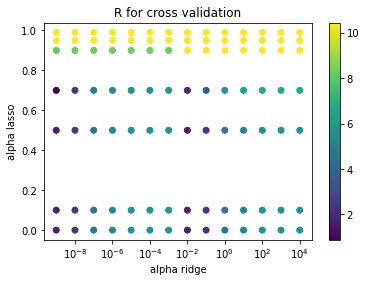

In [ ]:
from sklearn.linear_model import ElasticNet

def cross_validation(X, y, n_splits, alp_ridge, alp_lasso):
  length = int(len(y)/n_splits)
#  if len(y)%n_splits:
  R=0
  for i in range(0,n_splits):
    inter = [i for i in range(length*i, length*(i+1))] #Define the interval for test set

    #Define test set and train set
    X_cross_test = X[length*i:length*(i+1)]
    X_cross_train = X.drop(inter)
    y_cross_test = y[length*i:length*(i+1)]
    y_cross_train = y.drop(inter)

    #Normalization
    sc = StandardScaler()
    X_cross_train_norm = sc.fit_transform(X_cross_train)
    X_cross_test_norm = sc.transform(X_cross_test)
    y_cross_train = np.array(y_cross_train).reshape(-1,1)
    y_cross_test = np.array(y_cross_test).reshape(-1,1)
    y_cross_train_norm = sc.fit_transform(y_cross_train)
    y_cross_test_norm = sc.transform(y_cross_test)

    #sklearn elastic net
    elastic = ElasticNet(alpha=alp_ridge*2+alp_lasso, l1_ratio=alp_ridge*2/(alp_ridge*2+alp_lasso)) #because a*||w||_1+0.5*b*||w||_2^2, alpha=a+b and l1_ratio=a/(a+b)
    elastic.fit(X_cross_train_norm, y_cross_train_norm)

    y_cross_predict = elastic.predict(X_cross_test_norm)
    mse = mean_squared_error(y_cross_test_norm, y_cross_predict)
    R = R + mse
  return R

alp_ridge = [10e-10, 10e-9, 10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3]
alp_lasso = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
R_list = []
R_min = float("inf")
for a_ridge in alp_ridge: #For each alpha_ridge
  R_list_2=[]
  for a_lasso in alp_lasso: #For each alpha_lasso
    R = cross_validation(X, y, 10, a_ridge, a_lasso)
    R_list_2.append(R)
    """
    if R <= R_min:
      R_min = R
      #print(R, a_ridge, a_lasso) #value of R, alpha ridge, alpha lasso
    """
  R_list.append(R_list_2)
"""
Problems with plotting logarithmic axes, seems to be one of the bugs in the package matplotlib
ax.set_yscale('log') 
ax.set_xscale('log')

alp_ridge_list, alp_lasso_list = np.meshgrid(alp_ridge, alp_lasso)
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(alp_ridge_list, alp_lasso_list, np.array(pd.DataFrame(R_list).T))
fig.colorbar(surf)
plt.show()
"""
alp_ridge_list, alp_lasso_list = np.meshgrid(alp_ridge, alp_lasso)
plt.scatter(alp_ridge_list.reshape(-1,1), alp_lasso_list.reshape(-1,1), c=R_list)
plt.colorbar()
plt.xlabel('alpha ridge')
plt.ylabel('alpha lasso')
plt.xscale('log')
plt.title('R for cross validation')
plt.show()

8) Bootstrap and prediction intervals

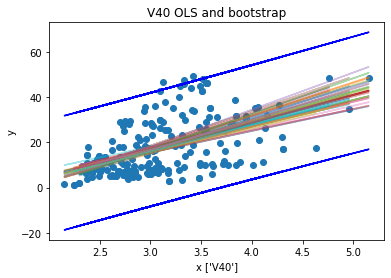

In [ ]:
from sklearn.utils import resample
from scipy.stats import t

#The dataset and the regression line fitted with the whole sample, use only variable V40
ls = LinearRegression()
ls.fit(X["V40"].values.reshape(-1, 1), y)
y_pre = ls.predict(X["V40"].values.reshape(-1, 1))
plt.scatter(X["V40"], y)
plt.plot(X["V40"], y_pre, label="all", color="red")

#50 bootstrap estimated regression lines
for i in range(0, 50):
  bootstrap = resample(data[["V40","fat"]], replace=True, n_samples=n) #Generate bootstrap samples
  ls_bootstrap = LinearRegression()
  ls_bootstrap.fit(bootstrap["V40"].values.reshape(-1, 1), bootstrap["fat"].values.reshape(-1, 1))
  y_pre_bootstrap = ls_bootstrap.predict(bootstrap["V40"].values.reshape(-1, 1))
  plt.plot(bootstrap["V40"], y_pre_bootstrap, label=i, alpha=.4)

#Prediction Intervals, lecture notes P26-27
sigma_hat = np.sqrt( np.sum(np.square(y - y_pre)) / (n-2) )
x_mean = np.mean(X["V40"])
interval = t.ppf(0.975, n-2)*sigma_hat*np.sqrt( 1 + (1/n) + ( np.square(X["V40"]-x_mean) / np.sum(np.square(X["V40"]-x_mean)) ) )
plt.plot(X["V40"], y_pre-interval, label="left", color="blue")
plt.plot(X["V40"], y_pre+interval, label="right", color="blue")

#plt.legend()
plt.xlabel("x ['V40']")
plt.ylabel("y")
plt.title("V40 OLS and bootstrap")
plt.show()

9) PCA

a) Heatmap of the covariance matrix

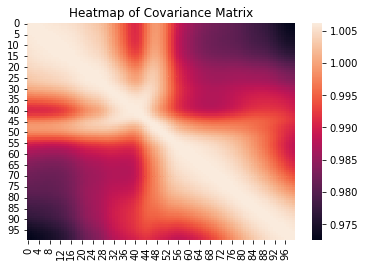

In [ ]:
import seaborn as sns

cov_matrix = np.cov(X_train_norm, rowvar=False) #If rowvar is True (default), then each row represents a variable, with observations in the columns
sns.heatmap(cov_matrix)
plt.title('Heatmap of Covariance Matrix')
plt.show()

b) c) The amount of variance explained by the first k components for k from 2 to p

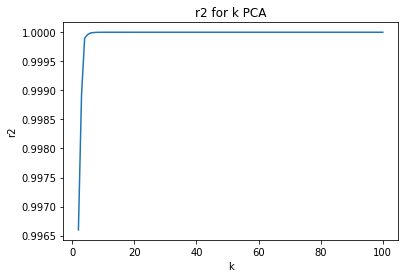

In [ ]:
U, s, Vt = np.linalg.svd(X_train_norm) #SVD decomposition
r2_SVD_list = []
for k in range(2, p+1):
  #reduced to k-dimensional
  s_reduced = np.diag(s[:k])
  U_reduced = U[:, :k]
  Vt_reduced = Vt[:k, :]
  X_train_norm_SVD = np.dot(U_reduced, s_reduced)
  
  r2_SVD = r2_score(X_train_norm, np.dot(X_train_norm_SVD, Vt_reduced))
  r2_SVD_list.append(r2_SVD)

plt.plot(range(2, p+1), r2_SVD_list)
plt.xlabel("k")
plt.ylabel("r2")
plt.title("r2 for k PCA")
plt.show()

d) The projected data, we can see some relationships with the color of y

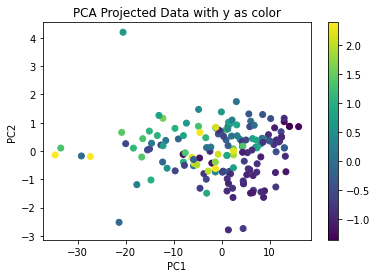

In [ ]:
k = 2
s_reduced = np.diag(s[:k])
U_reduced = U[:, :k]
Vt_reduced = Vt[:k, :]

plt.scatter(X_train_norm_SVD[:,0], X_train_norm_SVD[:,1], c=y_train_norm)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projected Data with y as color')
plt.show()

e) R2 score for OLS after PCA k=2 to p

In [ ]:
r2_SVD_max = float('-inf')
for k in range(2, p+1):
  s_reduced = np.diag(s[:k])
  U_reduced = U[:, :k]
  Vt_reduced = Vt[:k, :]
  X_train_norm_SVD = np.dot(U_reduced, s_reduced)

  ls = LinearRegression()
  ls.fit(X_train_norm_SVD, y_train_norm)
  y_predict_SVD = ls.predict(X_train_norm_SVD)
  r2_SVD = r2_score(y_train_norm, y_predict_SVD)
  if r2_SVD > r2_SVD_max:
    r2_SVD_max = r2_SVD

df_coef.loc[len(df_coef)] = r2_SVD_max #The best R2 is when k=100
print(df_coef)

         r2
0  0.960055
1  0.961149
2  0.948977
3  0.999900
4  0.935080
5  0.995789


10) Comparison of the models

The order of stored r2 values is OLS, my forward selection, sfs, Ridge, Lasso, PCA. These are algorithms for analyzing complex data and reducing dimensions.

What we can see from list of r2 is that our models have little loss of fit.

Forward selection and sfs method are to select the parameters that have the greatest impact on the model.

Ridge, lasso and elastic Net compress the coefficient by adding penalty items to prevent overfitting, but ridge cannot compress the coefficient to 0.

PCA maps data to lower dimensions through matrix decomposition and dimensionality reduction and keep the most important ingredients. And unlike other methods, PCA processes data before model learning.

Cross-validation is used to evaluate the model.

Bootstrap generates multiple samples from the original data set by resampling, which can be used to build confidence intervals.